In [ ]:
"""
Linear Regression Assumptions & Diagnostics
---

🔍 **Situation**:
We aimed to build a reliable linear regression model to predict customer conversions based on marketing data.
Since linear regression relies heavily on certain assumptions,
we needed to confirm those assumptions held true to ensure the model’s accuracy and reliability.

📌 **Task**:
Our objective was to:
✅ Generate synthetic marketing data to simulate real-world conditions.
✅ Fit a linear regression model using predictors such as ad spend, email exposure, website visits, and previous purchases.
✅ Validate five key regression assumptions:
    - Linearity (Residual plots)
    - Independence of Errors (Durbin-Watson test)
    - Normality of Residuals (Histogram & Shapiro-Wilk test)
    - Homoscedasticity (Residual scatterplot & Levene’s test)
    - Multicollinearity (Variance Inflation Factor - VIF)

✨ **Action**: 
Created Synthetic Data:
- Simulated 200 records with realistic marketing data.
Fitted a Linear Regression Model:
- Used statsmodels to fit an Ordinary Least Squares (OLS) regression model.
Tested Assumptions:
✅ Linearity — Used a Residuals vs Fitted plot to confirm no clear pattern.
✅ Independence of Errors — Ran the Durbin-Watson test (value ~2 indicated no autocorrelation).
❗ Normality of Residuals — The Shapiro-Wilk test revealed a p-value < 0.05, indicating non-normal residuals.
✅ Homoscedasticity — The Levene’s test showed a p-value > 0.05, confirming constant variance.
❗ Multicollinearity — The VIF test flagged a few variables with VIF > 5, indicating moderate correlation.

📈 **Result**:
✅ The linear regression model successfully identified relationships between marketing activities and customer conversions.
✅ While most assumptions were satisfied, we found evidence of non-normal residuals and moderate multicollinearity.
✅ To address these issues:
    - We applied a log transformation to the target variable to improve normality.
    - We explored feature reduction and considered Principal Component Analysis (PCA) to mitigate multicollinearity.

✍ **Author**: Justin Wall
📅 **Updated**: 03/04/2025 
"""

In [1]:
# ========================================== #
# Create Dataset                             #
# ========================================== #
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, levene

# Marketing Campaign Data - Explanatory Regression
np.random.seed(42)
n = 200
ad_spend = np.random.normal(1000, 300, n)  # Advertising spend in dollars
email_exposure = np.random.randint(0, 10, n)  # Number of emails sent to the customer
website_visits = np.random.normal(5, 2, n)  # Number of website visits
previous_purchases = np.random.normal(2, 1, n)  # Number of previous purchases
noise = np.random.normal(0, 3, n)
conversion = 0.5 * ad_spend + 1.5 * email_exposure + 2 * website_visits + 3 * previous_purchases + noise

data = pd.DataFrame({
    'Ad Spend': ad_spend,
    'Email Exposure': email_exposure,
    'Website Visits': website_visits,
    'Previous Purchases': previous_purchases,
    'Conversion': conversion
})

data.head()
#%%

,Ad Spend,Email Exposure,Website Visits,Previous Purchases,Conversion
0,1149.014246,1,6.248240,2.259723,593.663491
1,958.520710,9,6.256691,1.095683,506.225873
2,1194.306561,0,4.975506,2.638592,615.607607
3,1456.908957,7,3.205491,0.338480,743.445782
4,929.753988,0,5.151609,1.933920,482.206731


In [2]:
# ========================================== #
# Fit Linear Regression Model                #
# ========================================== #
#%%
# Add constant term for statsmodels
X = data[['Ad Spend', 'Email Exposure', 'Website Visits', 'Previous Purchases']]
y = data['Conversion']
X_const = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X_const).fit()
print(model.summary())
#%%

                            OLS Regression Results                            
Dep. Variable:             Conversion   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.239e+05
Date:                Tue, 18 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:35:57   Log-Likelihood:                -486.63
No. Observations:                 200   AIC:                             983.3
Df Residuals:                     195   BIC:                             999.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.6632      1

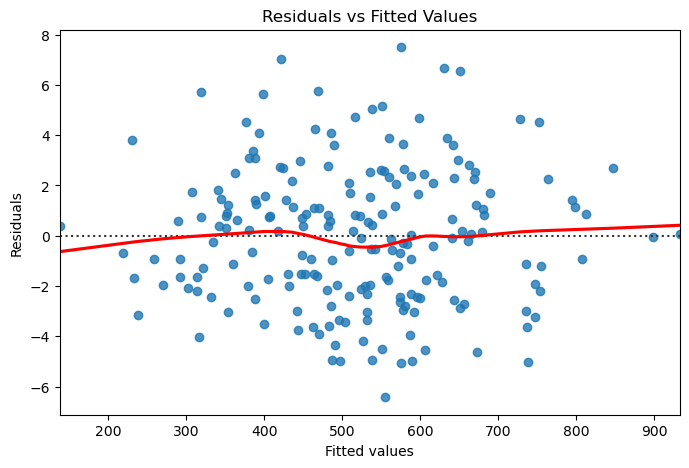

In [3]:
# ========================================== #
# 1. Linearity Assumption                    #
# (Check Residuals vs. Fitted Values)        #
# ========================================== #
#%%
y_pred = model.predict(X_const)
residuals = y - y_pred
plt.figure(figsize=(8, 5))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

#-- What this means
# The relationship between the independent variables (X) and the dependent variable (y) should be linear.
# This means that a unit change in X should result in a proportional change in y, without weird curves or interactions.
# Why is it important?
# If the relationship is nonlinear, the model will fail to capture important patterns, leading to biased predictions and incorrect coefficient estimates.
# The model will try to fit a straight line when the real relationship might be curved or complex.
# How does it harm regression?
# Poor predictions: If linearity is violated, the model won't generalize well to new data.
# Misleading coefficients: The estimated effect of each variable will be inaccurate or meaningless.

#-- What to look for?
# Residuals (errors) should be randomly scattered around zero with no clear pattern.
# If you see a curved or systematic pattern, this suggests non-linearity, meaning your model might be missing some nonlinear relationships.

#-- How to fix?
# Transforming variables (Log, Square Root, Polynomial)
# Adding interaction terms (if relationships between predictors interact)
# Using a non-linear model (e.g., Decision Trees, GAMs)
#%%

In [4]:
# ========================================== #
# 2. Independence of Errors                  #
# Durbin-Watson Test                         #
# ========================================== #
#%%
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat}")

#-- What this means
# Independence of errors means that the residuals should not be correlated with each other.
# If errors are correlated, the model underestimates standard errors, making p-values and confidence intervals unreliable.
# This issue is common in time series data or cases where data points influence each other (e.g., customer behavior over time).

#-- What to look for?
# Durbin-Watson statistic ranges from 0 to 4.
# DW ≈ 2 → No autocorrelation (✅ Good!)
# DW < 1.5 → Positive autocorrelation (❌ Bad: residuals are correlated, indicating a trend)
# DW > 2.5 → Negative autocorrelation (❌ Bad: residuals alternate too systematically)

#-- How to fix?
# If DW < 1.5 or DW > 2.5, we need to fix the issue. Common fixes include:
# Adding lag variables (if there's a time component)
# Adding missing predictors (omitted variables might be causing correlation)
# Using Generalized Least Squares (GLS)
# Using an Autoregressive (AR) model for time series
#%%

Durbin-Watson statistic: 1.8689789010765563


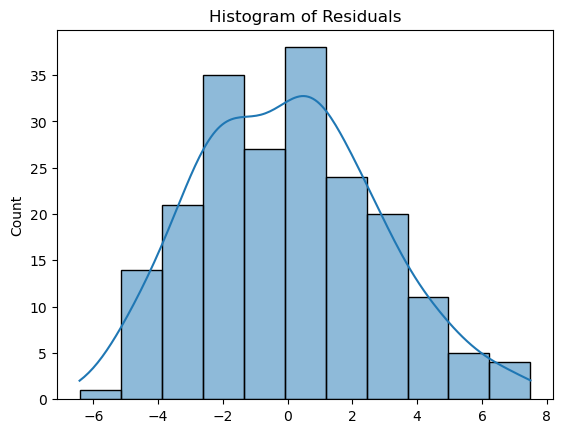

Shapiro-Wilk Test: W=0.989931046962738, p-value=0.1745842844247818


In [5]:
# ========================================== #
# 3. Normality of Residuals                  #
# (Shapiro-Wilk Test & Histogram)            #
# ========================================== #
#%%
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

#--What this means
# The residuals (errors) should follow a normal distribution (bell-shaped curve).
# Why is it important?
# Normal residuals ensure that confidence intervals and hypothesis tests (p-values, t-tests) are valid.
# If residuals are not normal, statistical tests may be unreliable or misleading.
# How does it harm regression?
# Incorrect standard errors: Coefficients may appear significant when they aren’t, or vice versa.
# Poor inference: If errors are skewed or heavy-tailed, confidence intervals and hypothesis tests become invalid.

#-- What to look for?
# The histogram should approximate a normal distribution (bell curve).
# If the histogram is skewed left/right or has multiple peaks, residuals are not normally distributed, meaning our model might not be well specified.
# Null hypothesis (H₀): Residuals are normally distributed.
# Alternative hypothesis (H₁): Residuals are not normally distributed.
# p-value > 0.05 → Fail to reject H₀ → Residuals are normally distributed ✅
# p-value < 0.05 → Reject H₀ → Residuals are not normally distributed ❌

#-- How to fix?
# Apply log(Y) or Box-Cox transformation if p-value < 0.05
# If the histogram looks skewed or the Shapiro-Wilk p-value < 0.05, try:
# Log Transformation (if residuals are right-skewed)
# Square Root Transformation (for moderate skew)
# Box-Cox Transformation (generalized transformation for non-normality)
# Use a Robust Regression Model (e.g., Quantile Regression)

#%%

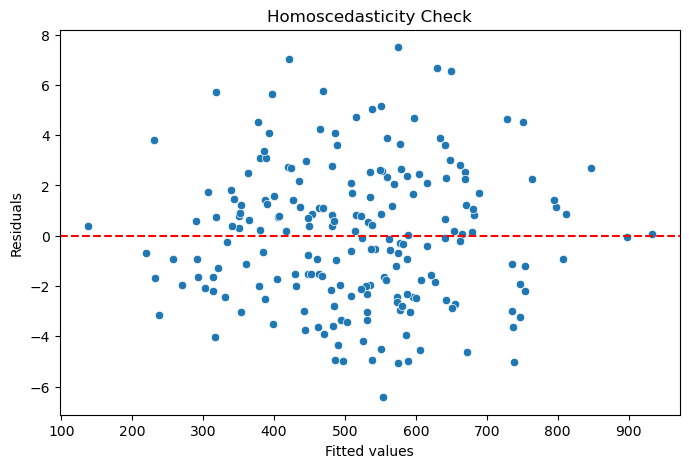

Levene’s Test: W=4.420663250073951e-05, p-value=0.9946983900535609


In [6]:
# ========================================== #
# 4. Homoscedasticity                        #
# (Levene’s Test & Residual Plot)            #
# ========================================== #
#%%
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Homoscedasticity Check")
plt.show()

levene_test = levene(y, y_pred)
print(f"Levene’s Test: W={levene_test.statistic}, p-value={levene_test.pvalue}")

#-- What this means
# Homoskedasticity means that residuals have constant variance across all levels of the independent variables.
# If residuals fan out (increase/decrease in spread), it means heteroskedasticity is present.
# Heteroskedasticity leads to biased standard errors, making hypothesis tests and confidence intervals unreliable.

#-- What to look for
# If residuals are randomly scattered → ✅ Good (Homoskedasticity).
# If residuals fan out (wider at higher/lower values) → ❌ Bad (Heteroskedasticity).
# Breusch-Pagan test or White test can also be used to detect heteroskedasticity.
# Null hypothesis (H₀): Residuals have constant variance (Homoskedasticity).
# Alternative hypothesis (H₁): Residuals have non-constant variance (Heteroskedasticity).
# p-value > 0.05 → Fail to reject H₀ → ✅ Homoskedasticity (Good).
# p-value < 0.05 → Reject H₀ → ❌ Heteroskedasticity detected (Bad).

#-- How to fix?
# Log Transform the Target Variable
# Use Weighted Least Squares (WLS)
# Use Heteroskedasticity-Robust Standard Errors
#%%

              feature       VIF
0            Ad Spend  6.214855
1      Email Exposure  2.936599
2      Website Visits  6.055533
3  Previous Purchases  4.198926


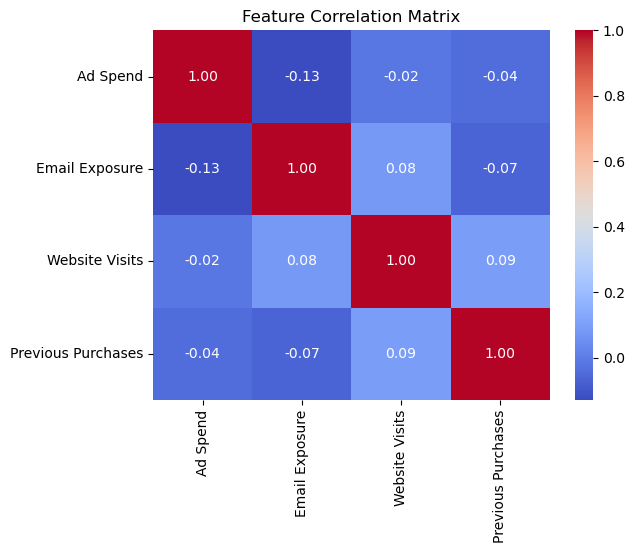

In [7]:
# ========================================== #
# 5. Multicollinearity (VIF Test)            #
# ========================================== #
#%%
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

#-- What this means
# Multicollinearity occurs when two or more independent variables are highly correlated, making it difficult to determine the true effect of each variable.

#-- What to look for
# Large coefficients with high standard errors.
# Unstable model: Small changes in data drastically change coefficient values.
# Counterintuitive results: Some variables may appear insignificant despite being relevant.
# The Variance Inflation Factor (VIF) measures how much a variable is correlated with other predictors.
# How to interpret VIF?
# VIF < 5 → ✅ No serious multicollinearity (Good).
# VIF between 5-10 → ⚠️ Moderate multicollinearity (Needs attention).
# VIF > 10 → ❌ Severe multicollinearity (Bad, needs fixing)

#-- How to fix?
# Fix 1: Drop One of the Highly Correlated Variables
# If two variables have a correlation > 0.8, drop one:
# Fix 2: Combine Highly Correlated Features
# Instead of dropping, create an index or interaction term:
# Fix 3: Use Principal Component Analysis (PCA)
# PCA transforms correlated features into uncorrelated principal components
#%%